In [6]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

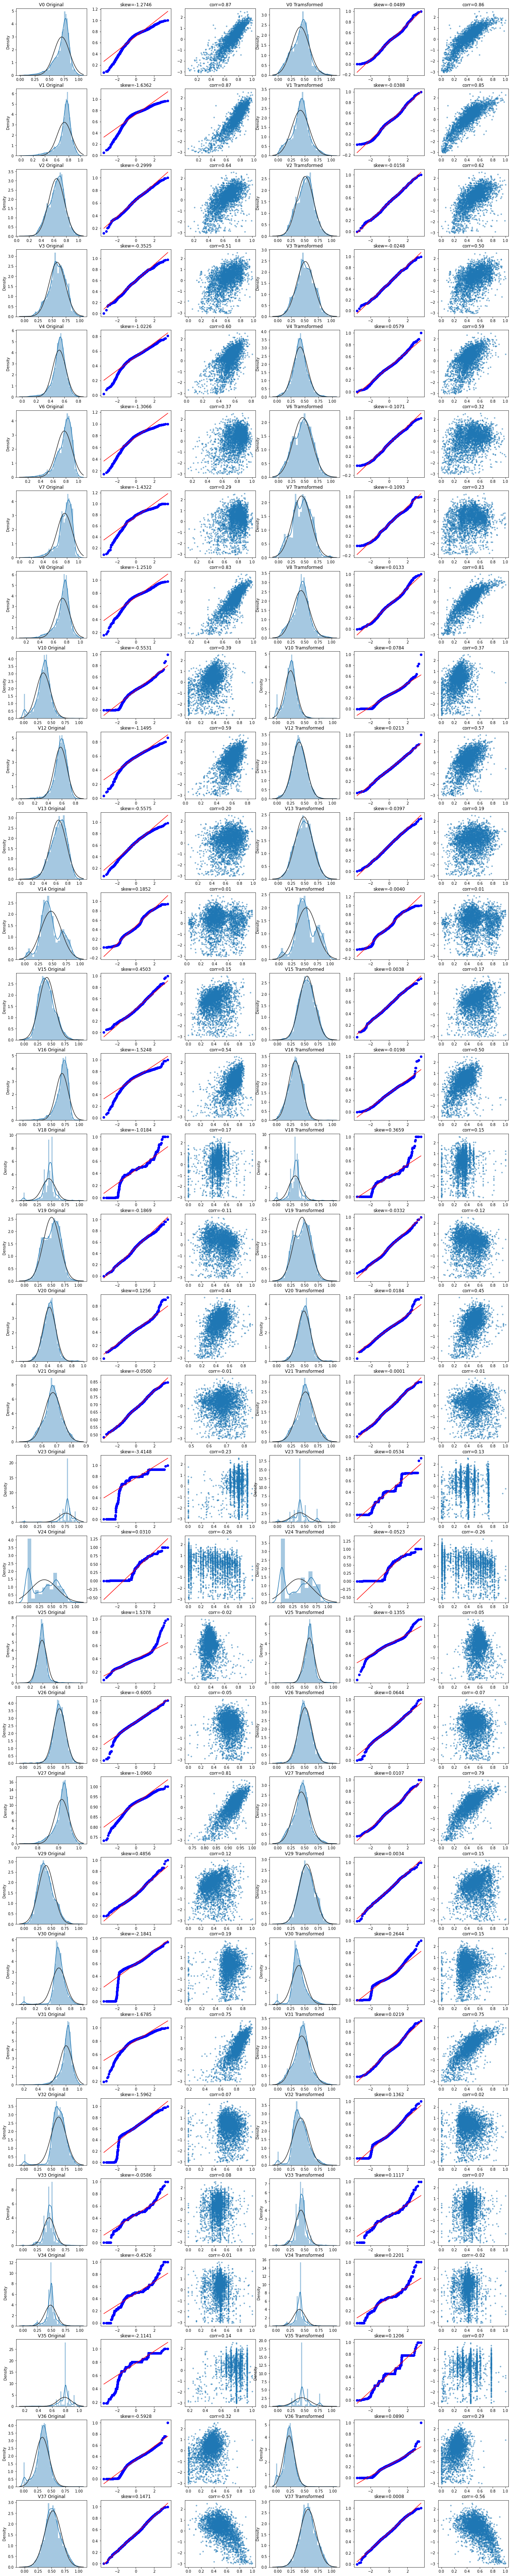

In [7]:
#load_dataset
with open("./data/zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./data/zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

#merge train_set and test_set
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)

data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

# normalise numeric columns
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)

#Check effect of Box-Cox transforms on distributions of continuous variables

fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()

        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')

        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')

        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))

        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')

        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')

        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64
count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


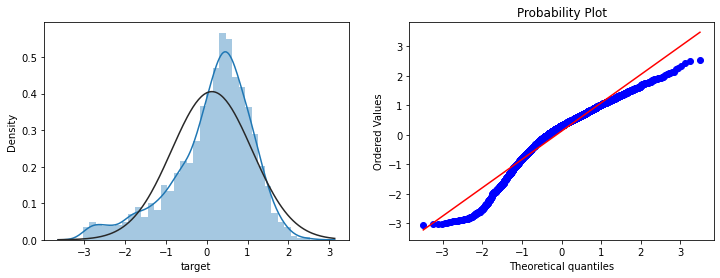

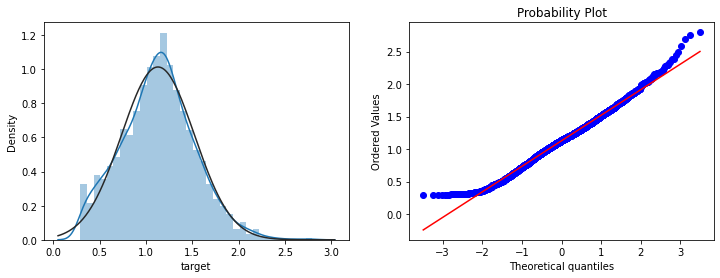

In [10]:
cols_transform=data_all.columns[0:-2]
for col in cols_transform:
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)

print(data_all.target.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

#Log Transform SalePrice to improve normality
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

In [11]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

In [12]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)
    n = len(y_pred)

    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

In [13]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)

    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid
    outliers = z[abs(z)>sigma].index

    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')

    plt.savefig('outliers.png')

    return outliers

R2= 0.8788526993921777
rmse= 0.34590542552970976
mse= 0.11965056341088962
---------------------------------------
mean of residuals: -1.1294500438541918e-16
std of residuals: 0.3459910350906122
---------------------------------------
24 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 1979, 2769, 2002, 2669, 1040]


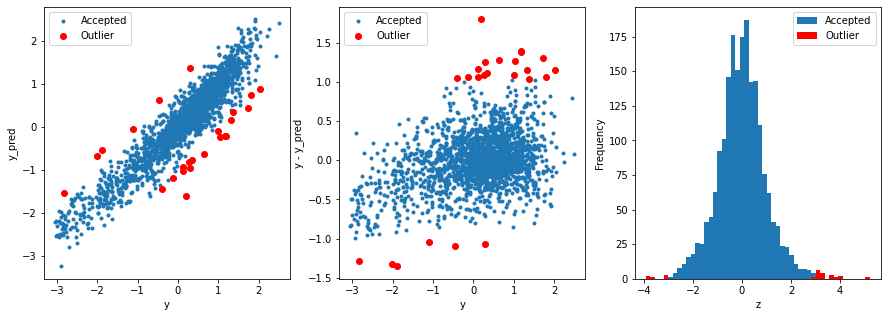

In [14]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

In [15]:
def get_trainning_data_omitoutliers():
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

In [16]:

from sklearn.preprocessing import StandardScaler
def train_model(model, param_grid=[], X=[], y=[],
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        #poly_trans=PolynomialFeatures(degree=2)
        #X=poly_trans.fit_transform(X)
        #X=MinMaxScaler().fit_transform(X)

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)

    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)

    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)

    # print stats on model performance
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)

    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid
    n_outliers = sum(abs(z)>3)

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [17]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Ridge(alpha=0.25)
----------------------
score= 0.8962818814684764
rmse= 0.31906002549328294
mse= 0.1017992998677743
cross_val: mean= 0.10616287951699518 , std= 0.006457919210235417


Text(0, 0.5, 'score')

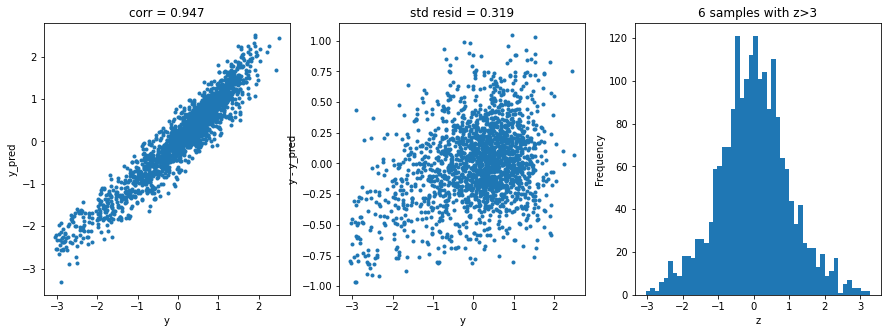

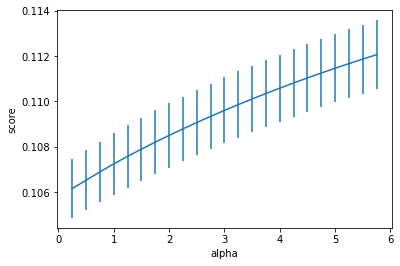

In [18]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Lasso(alpha=0.0001)
----------------------
score= 0.8964039001922659
rmse= 0.31887229188148625
mse= 0.10167953852975166
cross_val: mean= 0.10626962326857434 , std= 0.007259807830824154


Text(0, 0.5, 'score')

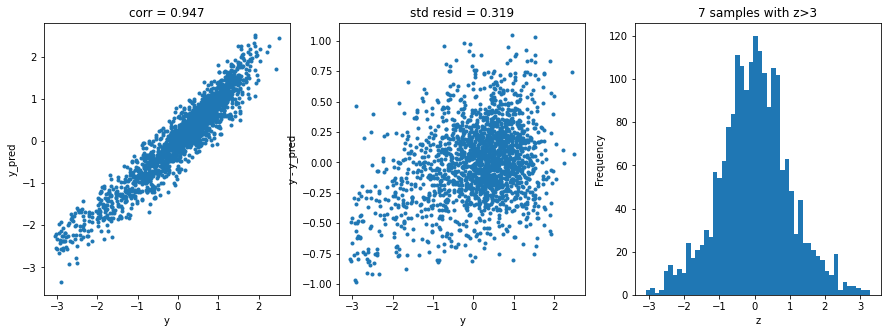

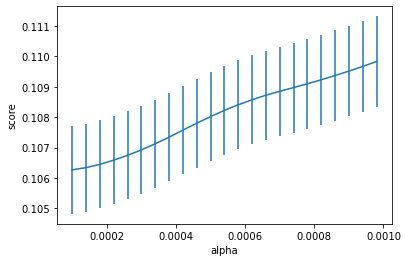

In [19]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------
ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=100000)
----------------------
score= 0.8963986353074553
rmse= 0.31888039452511674
mse= 0.10168470601249417
cross_val: mean= 0.10485366028285359 , std= 0.006183928204503285


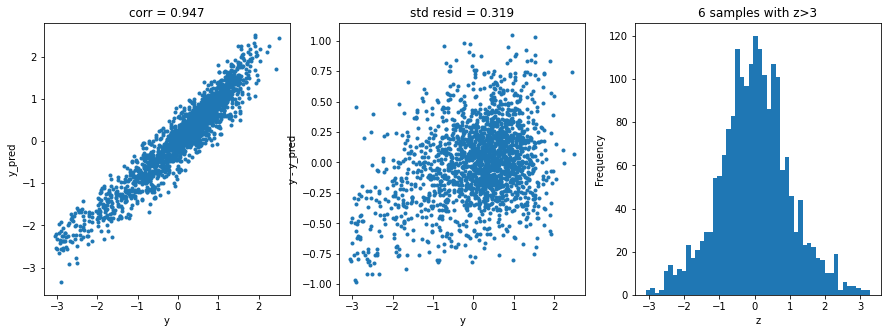

In [20]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 25 folds for each of 9 candidates, totalling 225 fits
----------------------
LinearSVR(C=0.4)
----------------------
score= -0.10030985738132414
rmse= 1.039208241854505
mse= 1.07995376993833
cross_val: mean= 1.9470796934561165 , std= 4.097419579562231


Text(0, 0.5, 'score')

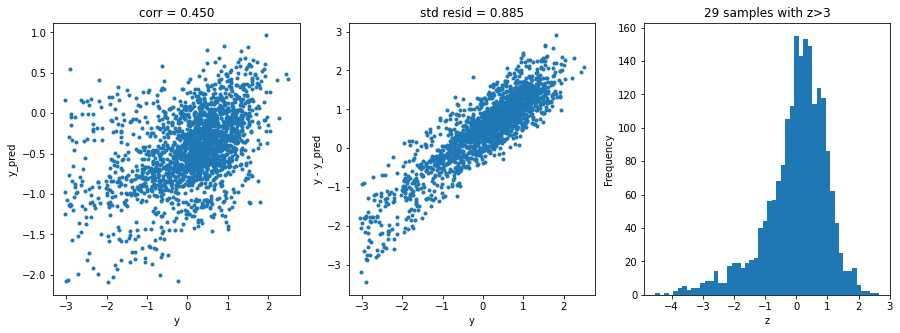

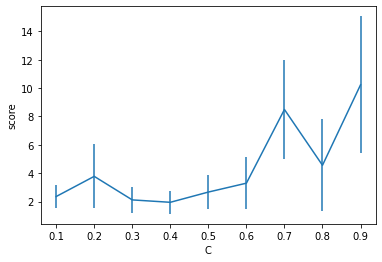

In [21]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------
KNeighborsRegressor(n_neighbors=10)
----------------------
score= 0.7183146849500659
rmse= 0.5258079933005283
mse= 0.2764740458187281
cross_val: mean= 0.3460632689657017 , std= 0.03429080952544729


Text(0, 0.5, 'score')

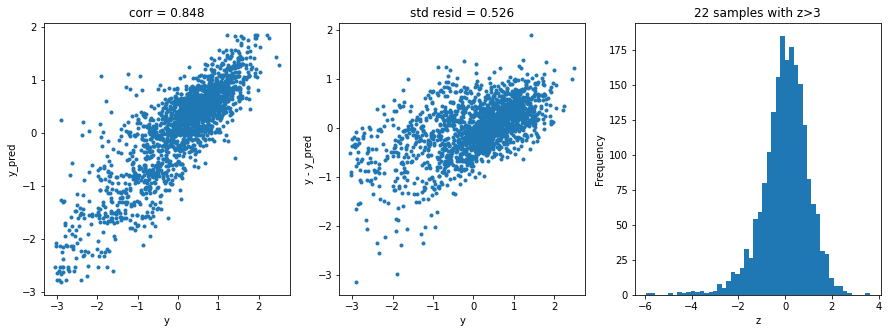

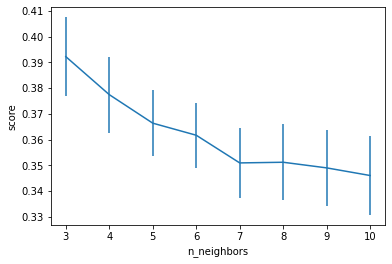

In [22]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------------------
GradientBoostingRegressor(min_samples_split=5, n_estimators=150)
----------------------
score= 0.9543331259985222
rmse= 0.2117121208038761
mse= 0.0448220220952751
cross_val: mean= 0.09885041220308902 , std= 0.007891377880184245


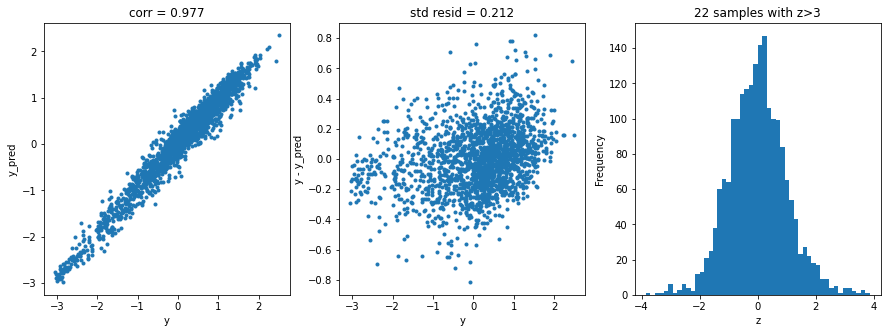

In [23]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
----------------------
score= 0.9702723836773041
rmse= 0.170814653432646
mse= 0.02917764582731493
cross_val: mean= 0.10110325188186338 , std= 0.007712637486352319


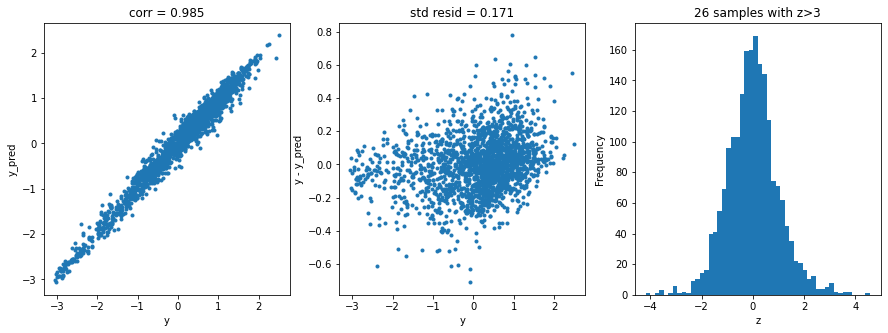

In [24]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------------------
RandomForestRegressor(max_features=20, n_estimators=200)
----------------------
score= 0.98549153664968
rmse= 0.11933168940523302
mse= 0.014240052096306964
cross_val: mean= 0.1022057113671998 , std= 0.007618139747915303


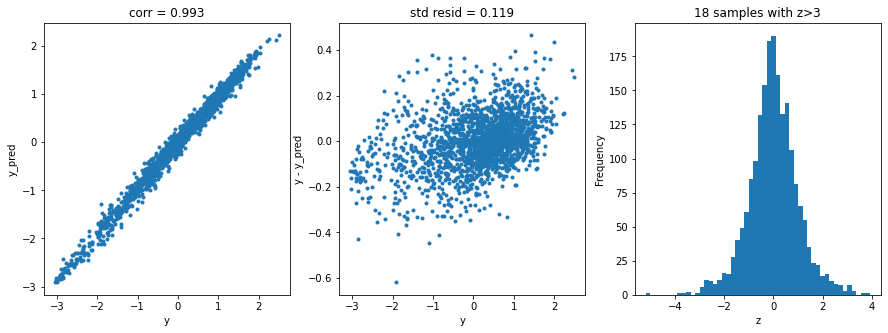

Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------------------
RandomForestRegressor(max_features=16, min_samples_split=4, n_estimators=200)
----------------------
score= 0.9839811250854628
rmse= 0.12538947547206955
mse= 0.01572252055916072
cross_val: mean= 0.10312795337835205 , std= 0.007251342485905803


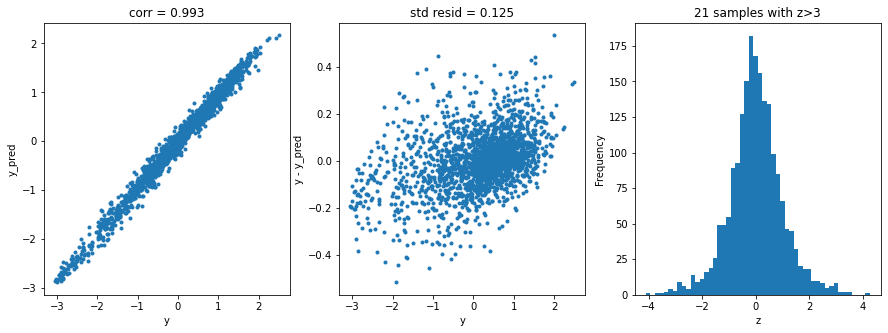

Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------------------
RandomForestRegressor(max_features=12, min_samples_split=6, n_estimators=200)
----------------------
score= 0.9799034567550273
rmse= 0.14044483155167034
mse= 0.019724750709577025
cross_val: mean= 0.10254035166760078 , std= 0.005623899795100338


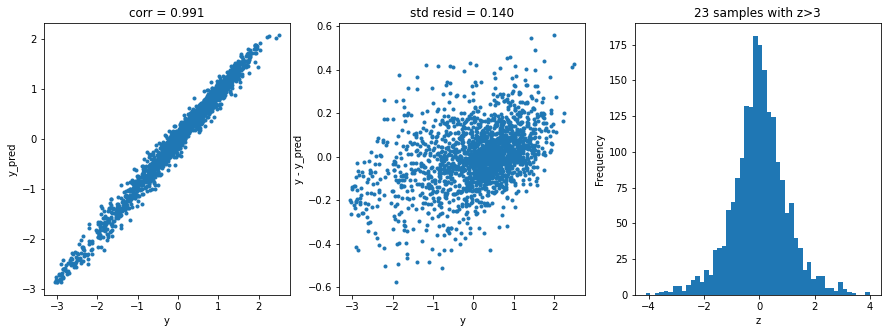

In [27]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[8,12,16,20,24],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

In [28]:
def model_predict(test_data,test_y=[],stack=False):
    #poly_trans=PolynomialFeatures(degree=2)
    #test_data1=poly_trans.fit_transform(test_data)
    #test_data=MinMaxScaler().fit_transform(test_data)
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [29]:
model_predict(X_valid,y_valid)

Ridge_mse: 0.1382568867887398
Lasso_mse: 0.13841422872992215
ElasticNet_mse: 0.1383905512382013
LinearSVR_mse: 0.1383905512382013
KNeighbors_mse: 0.1383905512382013
GradientBoosting_mse: 0.13830364948774101
XGB_mse: 0.14164156731951977
RandomForest_mse: 0.13943241287108674
mean_mse: 0.12694105074971165


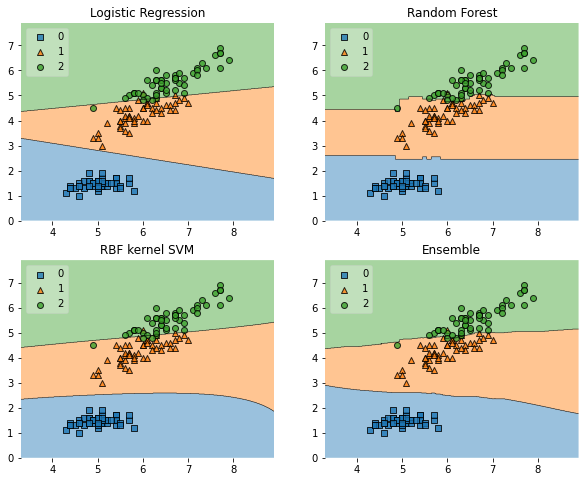

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##主要使用pip install mlxtend安装mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1))
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf","ada","gb","et","lr","lsvc","knn"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict(te_x).reshape(-1,1)
            train[test_index]=pre
            test_pre[i,:]=clf.predict(test_x).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {'booster': 'gbtree',
                      'eval_metric': 'rmse',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12
                      }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            #z = clf.Dataset(test_x, label=te_y)
            #z=test_x
            params = {
                      'boosting_type': 'gbdt',
                      'objective': 'regression_l2',
                      'metric': 'mse',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)


In [33]:

def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf_reg"

def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada_reg"

def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb_reg"

def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et_reg"

def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg=LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr_reg"

def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb_reg"

def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return lgb_train, lgb_test,"lgb_reg"

In [34]:
def stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True):
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list=[]
        test_data_list=[]
        for clf in clf_list:
            train_data,test_data,clf_name=clf(x_train, y_train, x_valid, kf, label_split=label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis=1)
    test = np.concatenate(test_data_list, axis=1)

    if if_concat_origin:
        train = np.concatenate([x_train, train], axis=1)
        test = np.concatenate([x_valid, test], axis=1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    if clf_fin in ["rf","ada","gb","et","lr","lsvc","knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs=-1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1,1)
        return pred
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        test_matrix = clf.DMatrix(train, label=y_train, missing=-1)
        params = {'booster': 'gbtree',
                  'eval_metric': 'rmse',
                  'gamma': 1,
                  'min_child_weight': 1.5,
                  'max_depth': 5,
                  'lambda': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'eta': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12
                  }
        num_round = 10000
        early_stopping_rounds = 100
        watchlist = [(train_matrix, 'train'),
                     (test_matrix, 'eval')
                     ]
        model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                          early_stopping_rounds=early_stopping_rounds
                          )
        pre = model.predict(test,ntree_limit=model.best_ntree_limit).reshape(-1,1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label=y_train)
        test_matrix = clf.Dataset(train, label=y_train)
        params = {
                  'boosting_type': 'gbdt',
                  'objective': 'regression_l2',
                  'metric': 'mse',
                  'min_child_weight': 1.5,
                  'num_leaves': 2**5,
                  'lambda_l2': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'learning_rate': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12,
                  'silent': True,
                  }
        num_round = 10000
        early_stopping_rounds = 100
        model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                          early_stopping_rounds=early_stopping_rounds
                          )
        print('pred')
        pre = model.predict(test,num_iteration=model.best_iteration).reshape(-1,1)
        print(pre)
        return pre

In [38]:
# #load_dataset
with open("./data/zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./data/zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

In [42]:
from sklearn.model_selection import StratifiedKFold, KFold

folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [43]:
x_train = data_train[data_test.columns].values
x_valid = data_test[data_test.columns].values
y_train = data_train['target'].values

In [44]:
clf_list = [lr_reg, lgb_reg]
#clf_list = [lr_reg, rf_reg]

##很容易过拟合
pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split=None, clf_fin="lgb", if_concat_origin=True)

lr now score is: [0.11573216950871246]
lr now score is: [0.11573216950871246, 0.09417486426618928]
lr now score is: [0.11573216950871246, 0.09417486426618928, 0.10805046561851067]
lr now score is: [0.11573216950871246, 0.09417486426618928, 0.10805046561851067, 0.1242088706560156]
lr now score is: [0.11573216950871246, 0.09417486426618928, 0.10805046561851067, 0.1242088706560156, 0.11940113841914012]
lr_score_list: [0.11573216950871246, 0.09417486426618928, 0.10805046561851067, 0.1242088706560156, 0.11940113841914012]
lr_score_mean: 0.11231350169371361
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_co

In [45]:
pred

array([[ 0.41700189],
       [ 0.37101204],
       [ 0.1479981 ],
       ...,
       [-2.48570445],
       [-2.4264629 ],
       [-2.48367665]])